In [13]:
import nltk
#nltk.download('punkt')
import numpy as np
import string
import gensim.downloader as api
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Reshape, BatchNormalization, Conv2DTranspose, Convolution2D, Activation, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras.layers import LeakyReLU
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from scipy import stats
import xgboost as xg
from xgboost import plot_tree
import matplotlib.pyplot as plt

def read_and_preprocess_file(sentences_file, labels_file):
    
    sentences = list()
    labels = list()
    
    # Sentences pairs
    with open(sentences_file, "r") as file:

        for line in file:

            # To lower case
            line = line.lower()

            # Remove punctuation
            line = line.translate(str.maketrans({key: None for key in string.punctuation}))

            # Tokenize both sentences
            line = line.split('\t')

            sentence1 = nltk.word_tokenize(line[0])
            sentence2 = nltk.word_tokenize(line[1][:-1])

            # Save sentences
            sentences.append(list([sentence1, sentence2]))
    
    # Labels
    with open(labels_file, "r") as file:

        for line in file:

            # Save label
            labels.append(line[:-1])
            
    return sentences, labels


def sentence2embedded(sentence, model, model_tam_embedded, max_sentence_length):
    embedded_sentence = [model[elem].tolist() if elem in model.vocab else np.zeros(model_tam_embedded).tolist() for elem in sentence]

    for i in range(len(embedded_sentence), max_sentence_length):
        embedded_sentence.append(np.zeros(model_tam_embedded).tolist())
        
    return embedded_sentence
        
def pairsentences2embedded(sentence1, sentence2, model, model_tam_embedded, max_sentence_length):
    
    sentence1_emb = sentence2embedded(sentence1, model, model_tam_embedded, max_sentence_length)
    sentence2_emb = sentence2embedded(sentence2, model, model_tam_embedded, max_sentence_length)
    
    return sentence1_emb, sentence2_emb

        
def pairembeddedsentences2svd(embedded1, embedded2, model_tam_embedded, max_sentence_length):
    
    embedded1_np = np.array(embedded1).reshape(1, model_tam_embedded * max_sentence_length)
    embedded2_np = np.array(embedded2).reshape(1, model_tam_embedded * max_sentence_length)
    
    diff = np.absolute(embedded1_np - embedded2_np)
    hadamard = embedded1_np * embedded2_np
    
    return np.concatenate((diff, hadamard), axis=0).reshape(1, model_tam_embedded * max_sentence_length * 2)


def get_max_sentence_length(sentences_list):
    
    max_length = 0
    
    for i in range(0, len(sentences)):
        
        sentences_pair = sentences[i]
        
        for j in range(0, len(sentences_pair)):
            
            if len(sentences_pair[j]) > max_length:
                max_length = len(sentences_pair[j])
    
    return max_length

In [2]:
###############
# MODEL
###############
MODEL_TAM_EMBEDDED = 100
print("MODEL_TAM_EMBEDDED", MODEL_TAM_EMBEDDED)

# Glove vectors
word_vectors = api.load("glove-wiki-gigaword-100")

# Word2Vec vectors
#word_vectors = api.load("word2vec-google-news-300")

MODEL_TAM_EMBEDDED 100


In [3]:
# Sentences and labels preprocessed
sentences, labels = read_and_preprocess_file("./data/train/STS.input.MSRpar.txt", "./data/train/STS.gs.MSRpar.txt")

sentences_aux, labels_aux = read_and_preprocess_file("./data/train/STS.input.MSRvid.txt", "./data/train/STS.gs.MSRvid.txt")

for i in range(0, len(sentences_aux)):
    
    sentences.append(sentences_aux[i])
    labels.append(labels_aux[i])

# MAX SENTENCE LENGTH
MAX_SENTENCE_LENGTH = get_max_sentence_length(sentences)
print("MAX_SENTENCE_LENGTH", MAX_SENTENCE_LENGTH)

# Get final embeddeds
final_sentences = list()

for i in range(0, len(sentences)):
    
    emb1, emb2 = pairsentences2embedded(sentences[i][0], sentences[i][1], word_vectors, MODEL_TAM_EMBEDDED, MAX_SENTENCE_LENGTH)
    final_sentences.append(pairembeddedsentences2svd(emb1, emb2, MODEL_TAM_EMBEDDED, MAX_SENTENCE_LENGTH))
    
print("FINAL SHAPE INPUT", final_sentences[0].shape)
print("NUM OF INSTANCES", len(final_sentences))
print("LE DAMOS OTRA VUELTA DE TUERCA")

final_sentences_reshaped = list()

for i in range(0, len(final_sentences)):
    final_sentences_reshaped.append(np.array(final_sentences[i]).flatten())
    
print("FINAL SHAPE INPUT", final_sentences_reshaped[0].shape)

MAX_SENTENCE_LENGTH 30
FINAL SHAPE INPUT (1, 6000)
NUM OF INSTANCES 1500
LE DAMOS OTRA VUELTA DE TUERCA
FINAL SHAPE INPUT (6000,)


In [4]:
#comput = word_vectors['computer']
#'computer' in word_vectors.vocab
#api.info()

In [5]:
#print("Lista: ", final_sentences)
final_sentences_reshaped = np.array(final_sentences_reshaped)
labels = np.array(labels).astype("float32")
labels = np.interp(labels, (labels.min(), labels.max()), (0, +1))

#print("A ver: ", final_sentences_reshaped.shape)
#print("A ver2: ", labels.shape)
#print(labels)
#print("Interp: ", np.interp(labels, (labels.min(), labels.max()), (0, +1)))
X_trn = final_sentences_reshaped[:1300]
Y_trn = labels[:1300]
X_tst = final_sentences_reshaped[1300:]
Y_tst = labels[1300:]

# XGBOOST
xgb = xg.XGBRegressor(objective='reg:linear', n_estimators=500, max_depth=4, learning_rate=0.01, gamma=0, subsample=0.50, colsample_bytree=0.6)
xgb.fit(X_trn, Y_trn)

real = Y_tst
predecido = xgb.predict(X_tst)

pearson_coef, p_value = stats.pearsonr(real, predecido) #define the columns to perform calculations on
print("Pearson Correlation Coefficient: ", pearson_coef, "and a P-value of:", p_value) # Results

'''# KERAS FCNN MODEL
from keras.applications.vgg19 import VGG19
model = VGG19(include_top=False, weights='imagenet', input_shape=(100, 60, 3))

# Modificaciones
x = model.output
x = GlobalAveragePooling2D()(x)
#x = Flatten()
x = Dense(1024, activation='sigmoid')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x = Dense(1024, activation='sigmoid')(x) #dense layer 2
x = Dense(512, activation='sigmoid')(x) #dense layer 3
preds = Dense(1, activation='softmax')(x) #final layer with softmax activation

model = Model(inputs=model.input, outputs=preds)

model = tf.contrib.tpu.keras_to_tpu_model(model, strategy=tf.contrib.tpu.TPUDistributionStrategy(
    tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://10.0.101.2:8470')))

model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])

model.summary()

model.fit(final_sentences_reshaped, labels, batch_size=32, epochs=200, verbose=2)


# Keras FCNN model
fcnn = Sequential()
fcnn.add(Dense(300, input_shape=(180, 100), activation='tanh', kernel_initializer='normal'))
fcnn.add(Flatten())
fcnn.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

fcnn.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])

fcnn.summary()

#fcnn.fit(final_sentences, labels, epochs=6, batch_size=32)

early_stopping = EarlyStopping(monitor='loss', patience=3)
#fcnn.fit(final_sentences_reshaped, labels, batch_size=32, epochs=200, verbose=2, validation_data=(final_sentences_reshaped, labels), callbacks=[early_stopping])
fcnn.fit(final_sentences_reshaped, labels, batch_size=32, epochs=200, verbose=2, callbacks=[early_stopping])
#fcnn.predict(X_trn, batch_size=1, verbose=2, steps=None)'''

Pearson Correlation Coefficient:  0.5198658219353182 and a P-value of: 3.055678636350304e-15


"# KERAS FCNN MODEL\nfrom keras.applications.vgg19 import VGG19\nmodel = VGG19(include_top=False, weights='imagenet', input_shape=(100, 60, 3))\n\n# Modificaciones\nx = model.output\nx = GlobalAveragePooling2D()(x)\n#x = Flatten()\nx = Dense(1024, activation='sigmoid')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.\nx = Dense(1024, activation='sigmoid')(x) #dense layer 2\nx = Dense(512, activation='sigmoid')(x) #dense layer 3\npreds = Dense(1, activation='softmax')(x) #final layer with softmax activation\n\nmodel = Model(inputs=model.input, outputs=preds)\n\nmodel = tf.contrib.tpu.keras_to_tpu_model(model, strategy=tf.contrib.tpu.TPUDistributionStrategy(\n    tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://10.0.101.2:8470')))\n\nmodel.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])\n\nmodel.summary()\n\nmodel.fit(final_sentences_reshaped, labels, batch_size=32, epochs=200, verbose=2)\n\n\n#

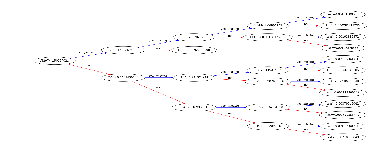

'Digraph.gv.png'

<Figure size 432x288 with 0 Axes>

In [23]:
plot_tree(xgb, rankdir="LR")
plt.show()
plt.savefig('tree1.png')

pp = xg.to_graphviz(xgb, num_trees=2, rankdir="LR")
pp.format = 'png'

pp.render()